In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time

### Task 1

Cargue el conjunto de datos de Iris utilizando bibliotecas como sklearn.datasets. Luego, divida el conjunto de datos  en conjuntos de entrenamiento y validación. 

In [13]:
iris = load_iris()
X = iris.data         
y = iris.target    

# Normalizar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Tamaño del set de entrenamiento:", len(train_dataset))
print("Tamaño del set de validación:", len(val_dataset))


Tamaño del set de entrenamiento: 105
Tamaño del set de validación: 45


### Task 2

Cree una red neuronal feedforward simple utilizando nn.Module de PyTorch. Luego, defina capa de entrada, capas  ocultas y capa de salida. Después, elija las funciones de activación y el número de neuronas por capa. 

In [14]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim=4, hidden1=16, hidden2=8, output_dim=3):
        super(FeedforwardNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))   
        x = self.relu(self.fc2(x))  
        x = self.fc3(x)            
        return x

model = FeedforwardNN()

print(model)


FeedforwardNN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
)


### Task 3

Utilice diferentes funciones de pérdida comunes como Cross-Entropy Loss y MSE para clasificación. Entrene el  modelo con diferentes funciones de pérdida y registre las pérdidas de entrenamiento y test. Debe utilizar al menos 3  diferentes funciones. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes funciones de  pérdida.  

In [15]:
def train_model(loss_fn_name, train_loader, val_loader, epochs=50, lr=0.01):
    input_dim, output_dim = 4, 3
    model = FeedforwardNN(input_dim=input_dim, output_dim=output_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_functions = {
        "cross_entropy": nn.CrossEntropyLoss(),
        "mse": nn.MSELoss(),
        "nll": nn.NLLLoss()
    }
    criterion = loss_functions[loss_fn_name]

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            outputs = model(X_batch)

            if loss_fn_name == "mse":
                y_batch_oh = nn.functional.one_hot(y_batch, num_classes=output_dim).float()
                loss = criterion(outputs, y_batch_oh)
            elif loss_fn_name == "nll":
                log_probs = nn.functional.log_softmax(outputs, dim=1)
                loss = criterion(log_probs, y_batch)
            else:
                loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)

                if loss_fn_name == "mse":
                    y_val_oh = nn.functional.one_hot(y_val, num_classes=output_dim).float()
                    loss = criterion(outputs, y_val_oh)
                elif loss_fn_name == "nll":
                    log_probs = nn.functional.log_softmax(outputs, dim=1)
                    loss = criterion(log_probs, y_val)
                else:
                    loss = criterion(outputs, y_val)

                val_loss += loss.item()

        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"[{loss_fn_name}] Epoch {epoch+1}/{epochs} "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, "
                  f"Val Loss: {history['val_loss'][-1]:.4f}")

    return history

losses = {}
for loss_name in ["cross_entropy", "mse", "nll"]:
    print(f"\nEntrenando con {loss_name.upper()}...\n")
    history = train_model(loss_name, train_loader, val_loader, epochs=50, lr=0.01)
    losses[loss_name] = history


Entrenando con CROSS_ENTROPY...

[cross_entropy] Epoch 10/50 Train Loss: 0.0966, Val Loss: 0.1570
[cross_entropy] Epoch 20/50 Train Loss: 0.0473, Val Loss: 0.1562
[cross_entropy] Epoch 30/50 Train Loss: 0.0266, Val Loss: 0.1373
[cross_entropy] Epoch 40/50 Train Loss: 0.0280, Val Loss: 0.1639
[cross_entropy] Epoch 50/50 Train Loss: 0.0173, Val Loss: 0.1479

Entrenando con MSE...

[mse] Epoch 10/50 Train Loss: 0.0319, Val Loss: 0.0436
[mse] Epoch 20/50 Train Loss: 0.0130, Val Loss: 0.0245
[mse] Epoch 30/50 Train Loss: 0.0101, Val Loss: 0.0242
[mse] Epoch 40/50 Train Loss: 0.0121, Val Loss: 0.0247
[mse] Epoch 50/50 Train Loss: 0.0088, Val Loss: 0.0271

Entrenando con NLL...

[nll] Epoch 10/50 Train Loss: 0.1083, Val Loss: 0.1907
[nll] Epoch 20/50 Train Loss: 0.0356, Val Loss: 0.1303
[nll] Epoch 30/50 Train Loss: 0.0409, Val Loss: 0.1711
[nll] Epoch 40/50 Train Loss: 0.0188, Val Loss: 0.1585
[nll] Epoch 50/50 Train Loss: 0.0133, Val Loss: 0.1754


### Task 4

Utilice distintas técnicas de regularización como L1, L2 y dropout. Entrene el modelo con y sin técnicas de  regularización y observe el impacto en el overfitting y la generalización. Debe utilizar al menos 3 diferentes técnicas.  Es decir, procure que su código sea capaz de parametrizar el uso de diferentes técnicas de regularización. 

In [20]:
def train_model_regularization(loss_fn_name="cross_entropy", train_loader=None, val_loader=None,
                               regularization=None, reg_lambda=0.01, epochs=100):
    
    model = FeedforwardNN(input_dim=4, output_dim=3)
    
    if loss_fn_name == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_fn_name == "mse":
        criterion = nn.MSELoss()
    elif loss_fn_name == "nll":
        criterion = nn.NLLLoss()
    else:
        raise ValueError("Función de pérdida no soportada.")
    
    # Optimizer con L2 si se selecciona
    optimizer = optim.Adam(model.parameters(), lr=0.01,
                           weight_decay=reg_lambda if regularization=="l2" else 0.0)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        batch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)

            if loss_fn_name == "mse":
                y_batch_oh = nn.functional.one_hot(y_batch, num_classes=3).float()
                loss = criterion(outputs, y_batch_oh)
            elif loss_fn_name == "nll":
                log_probs = nn.functional.log_softmax(outputs, dim=1)
                loss = criterion(log_probs, y_batch)
            else:
                loss = criterion(outputs, y_batch)

            if regularization == "l1":
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + reg_lambda * l1_norm

            loss.backward()
            optimizer.step()
            batch_train_loss += loss.item()

        train_losses.append(batch_train_loss / len(train_loader))

        model.eval()
        batch_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                if loss_fn_name == "mse":
                    y_batch_oh = nn.functional.one_hot(y_batch, num_classes=3).float()
                    loss = criterion(outputs, y_batch_oh)
                elif loss_fn_name == "nll":
                    log_probs = nn.functional.log_softmax(outputs, dim=1)
                    loss = criterion(log_probs, y_batch)
                else:
                    loss = criterion(outputs, y_batch)
                batch_val_loss += loss.item()

        val_losses.append(batch_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"[{loss_fn_name}] Epoch {epoch+1}/{epochs} "
                  f"Train Loss: {train_losses[-1]:.4f}, "
                  f"Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

print("\n=== Sin regularización (CrossEntropy) ===")
train_model_regularization(loss_fn_name="cross_entropy",
                           train_loader=train_loader,
                           val_loader=val_loader,
                           regularization=None,
                           epochs=50)

print("\n=== Regularización L2 ===")
train_model_regularization(loss_fn_name="cross_entropy",
                           train_loader=train_loader,
                           val_loader=val_loader,
                           regularization="l2",
                           reg_lambda=0.01,
                           epochs=50)

print("\n=== Regularización L1 ===")
train_model_regularization(loss_fn_name="cross_entropy",
                           train_loader=train_loader,
                           val_loader=val_loader,
                           regularization="l1",
                           reg_lambda=0.01,
                           epochs=50)



=== Sin regularización (CrossEntropy) ===
[cross_entropy] Epoch 1/50 Train Loss: 0.9925, Val Loss: 0.8452
[cross_entropy] Epoch 11/50 Train Loss: 0.0711, Val Loss: 0.1258
[cross_entropy] Epoch 21/50 Train Loss: 0.0382, Val Loss: 0.1297
[cross_entropy] Epoch 31/50 Train Loss: 0.0295, Val Loss: 0.1852
[cross_entropy] Epoch 41/50 Train Loss: 0.0205, Val Loss: 0.1571

=== Regularización L2 ===
[cross_entropy] Epoch 1/50 Train Loss: 1.0768, Val Loss: 0.9813
[cross_entropy] Epoch 11/50 Train Loss: 0.0706, Val Loss: 0.1257
[cross_entropy] Epoch 21/50 Train Loss: 0.0622, Val Loss: 0.1271
[cross_entropy] Epoch 31/50 Train Loss: 0.0505, Val Loss: 0.1347
[cross_entropy] Epoch 41/50 Train Loss: 0.0518, Val Loss: 0.1156

=== Regularización L1 ===
[cross_entropy] Epoch 1/50 Train Loss: 1.4000, Val Loss: 1.0108
[cross_entropy] Epoch 11/50 Train Loss: 0.6930, Val Loss: 0.5126
[cross_entropy] Epoch 21/50 Train Loss: 0.4939, Val Loss: 0.2841
[cross_entropy] Epoch 31/50 Train Loss: 0.4338, Val Loss: 0.2

([1.3999747037887573,
  1.235278878893171,
  1.124216045652117,
  1.058259972504207,
  0.9939755541937692,
  0.9243466428347996,
  0.8819808959960938,
  0.8255657127925328,
  0.7880617039544242,
  0.7312228083610535,
  0.6929844532694135,
  0.6571718880108425,
  0.6281284434454781,
  0.598013094493321,
  0.567102347101484,
  0.563959002494812,
  0.5334761696202415,
  0.5342325781072889,
  0.5063458936555045,
  0.5065822431019374,
  0.4939098613602774,
  0.4877473669392722,
  0.4684529347079141,
  0.4767651515347617,
  0.46279240931783405,
  0.46076370988573345,
  0.44302694712366375,
  0.44098777430398123,
  0.4395856431552342,
  0.4295825575079237,
  0.43375788416181293,
  0.42276023966925486,
  0.4328600083078657,
  0.41850124086652485,
  0.41168512191091267,
  0.4090933586869921,
  0.40827155113220215,
  0.4093503398554666,
  0.40553433128765654,
  0.4055331902844565,
  0.3967679100377219,
  0.39293050340243746,
  0.38991556423051016,
  0.40320644208363127,
  0.3971408222402845,
  0

### Task 5

Utilice distintas técnicas de optimización como SGD, Batch GD, Mini-Batch GD. Entrene el modelo con algoritmos de  optimización y registre las pérdidas y tiempos de entrenamiento y test. Debe utilizar al menos 3 diferentes algoritmos.  Es decir, procure que su código sea capaz de parametrizar el uso de diferentes algoritmos de optimización.  

In [22]:
def train_model_optim(loss_fn_name="cross_entropy", train_loader=None, val_loader=None,
                      optimizer_name="adam", batch_size=16, epochs=50, lr=0.01):
    
    input_dim, output_dim = 4, 3
    model = FeedforwardNN(input_dim=input_dim, output_dim=output_dim)
    
    loss_functions = {
        "cross_entropy": nn.CrossEntropyLoss(),
        "mse": nn.MSELoss(),
        "nll": nn.NLLLoss()
    }
    criterion = loss_functions[loss_fn_name]

    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError("Optimización no soportada")

    history = {"train_loss": [], "val_loss": [], "train_time": 0.0}

    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)

            if loss_fn_name == "mse":
                y_batch_oh = nn.functional.one_hot(y_batch, num_classes=output_dim).float()
                loss = criterion(outputs, y_batch_oh)
            elif loss_fn_name == "nll":
                log_probs = nn.functional.log_softmax(outputs, dim=1)
                loss = criterion(log_probs, y_batch)
            else:
                loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        history["train_loss"].append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)
                if loss_fn_name == "mse":
                    y_val_oh = nn.functional.one_hot(y_val, num_classes=output_dim).float()
                    loss = criterion(outputs, y_val_oh)
                elif loss_fn_name == "nll":
                    log_probs = nn.functional.log_softmax(outputs, dim=1)
                    loss = criterion(log_probs, y_val)
                else:
                    loss = criterion(outputs, y_val)
                val_loss += loss.item()
        history["val_loss"].append(val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"[{optimizer_name.upper()} | {loss_fn_name}] Epoch {epoch+1}/{epochs} "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, "
                  f"Val Loss: {history['val_loss'][-1]:.4f}")

    history["train_time"] = time.time() - start_time
    print(f"Tiempo total de entrenamiento con {optimizer_name.upper()}: {history['train_time']:.2f} s")
    
    return history

batch_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
train_model_optim(loss_fn_name="cross_entropy", train_loader=batch_loader,
                  val_loader=val_loader, optimizer_name="sgd", batch_size=len(train_dataset))

train_model_optim(loss_fn_name="cross_entropy", train_loader=train_loader,
                  val_loader=val_loader, optimizer_name="sgd", batch_size=16)

sgd_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_model_optim(loss_fn_name="cross_entropy", train_loader=sgd_loader,
                  val_loader=val_loader, optimizer_name="sgd", batch_size=1)

train_model_optim(loss_fn_name="cross_entropy", train_loader=train_loader,
                  val_loader=val_loader, optimizer_name="adam", batch_size=16)


[SGD | cross_entropy] Epoch 10/50 Train Loss: 1.1176, Val Loss: 1.1099
[SGD | cross_entropy] Epoch 20/50 Train Loss: 1.1093, Val Loss: 1.1042
[SGD | cross_entropy] Epoch 30/50 Train Loss: 1.1019, Val Loss: 1.0990
[SGD | cross_entropy] Epoch 40/50 Train Loss: 1.0958, Val Loss: 1.0942
[SGD | cross_entropy] Epoch 50/50 Train Loss: 1.0905, Val Loss: 1.0897
Tiempo total de entrenamiento con SGD: 0.12 s
[SGD | cross_entropy] Epoch 10/50 Train Loss: 1.1105, Val Loss: 1.1125
[SGD | cross_entropy] Epoch 20/50 Train Loss: 1.0844, Val Loss: 1.0909
[SGD | cross_entropy] Epoch 30/50 Train Loss: 1.0623, Val Loss: 1.0719
[SGD | cross_entropy] Epoch 40/50 Train Loss: 1.0327, Val Loss: 1.0470
[SGD | cross_entropy] Epoch 50/50 Train Loss: 0.9915, Val Loss: 1.0090
Tiempo total de entrenamiento con SGD: 0.22 s
[SGD | cross_entropy] Epoch 10/50 Train Loss: 0.2232, Val Loss: 0.2879
[SGD | cross_entropy] Epoch 20/50 Train Loss: 0.0807, Val Loss: 0.1352
[SGD | cross_entropy] Epoch 30/50 Train Loss: 0.0498, Va

{'train_loss': [0.9508827073233468,
  0.7249012291431427,
  0.5459460318088531,
  0.3934256434440613,
  0.2929522288697107,
  0.24170797318220139,
  0.19136374443769455,
  0.14217776459242618,
  0.1121454547558512,
  0.0893327673631055,
  0.06934472785464355,
  0.06323612574487925,
  0.05478259269148111,
  0.0541815043294004,
  0.0620681940178786,
  0.04266122356057167,
  0.04392902000940272,
  0.03602570425053792,
  0.03725146608693259,
  0.031241179709987982,
  0.02933008755956377,
  0.028903043030628135,
  0.029867252966921245,
  0.028012561611831188,
  0.035105986562224904,
  0.029263572334977134,
  0.032151972908260565,
  0.05637143825047782,
  0.06631934948797737,
  0.02457059665383505,
  0.041283142154238055,
  0.04073597191849591,
  0.03444064791048212,
  0.02759074528668342,
  0.021939921392393962,
  0.02310839497866774,
  0.020015340564506396,
  0.020398680933534967,
  0.01887124597227999,
  0.021005026547105184,
  0.018254985168044056,
  0.015524186509927469,
  0.01657999990

### Task 6

Entrene los modelos con diferentes combinaciones de funciones de pérdida, técnicas de regularización y algoritmos  de optimización. Para no complicar esta parte, puede dejar fijo dos de estos parámetros (función de pérdida, técnicas de regularización, algoritmo de optimización) y solamente cambiar uno de ellos. Deben verse al menos 9  combinaciones en total, donde es válido que en una de ellas no haya ninguna técnica de regularización. Si quiere  experimentar con más combinaciones se le dará hasta 10% de puntos extra.  

Para cada combinación registre métricas como precisión, pérdida y alguna otra métrica que considere pertinente  (Recuerde lo visto en inteligencia artificial). 

Visualice las curvas (tanto en precisión, pérdida y la tercera métrica que decidió) de entrenamiento y validación  utilizando bibliotecas como matplotlib y/o seaborn. Además, recuerde llevar tracking de los tiempos de ejecución de  cada combinación. 


In [26]:
def train_model_combination(loss_name="cross_entropy",
                            optimizer_name="adam",
                            regularization=None,
                            reg_lambda=0.01,
                            epochs=50):
    
    model = FeedforwardNN()
    
    loss_functions = {
        "cross_entropy": nn.CrossEntropyLoss(),
        "mse": nn.MSELoss(),
        "nll": nn.NLLLoss()
    }
    criterion = loss_functions[loss_name]
    
    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0 if regularization != "l2" else reg_lambda)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0 if regularization != "l2" else reg_lambda)
    else:
        raise ValueError("Optimización no soportada")
    
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "time": 0.0}
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        y_true_train, y_pred_train = [], []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            if loss_name == "mse":
                y_batch_oh = nn.functional.one_hot(y_batch, num_classes=3).float()
                loss = criterion(outputs, y_batch_oh)
            elif loss_name == "nll":
                log_probs = nn.functional.log_softmax(outputs, dim=1)
                loss = criterion(log_probs, y_batch)
            else:
                loss = criterion(outputs, y_batch)
            
            if regularization == "l1":
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += reg_lambda * l1_norm
                
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(y_batch.numpy())
            y_pred_train.extend(predicted.numpy())
        
        train_acc = accuracy_score(y_true_train, y_pred_train)
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_acc)
        
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                if loss_name == "mse":
                    y_batch_oh = nn.functional.one_hot(y_batch, num_classes=3).float()
                    loss = criterion(outputs, y_batch_oh)
                elif loss_name == "nll":
                    log_probs = nn.functional.log_softmax(outputs, dim=1)
                    loss = criterion(log_probs, y_batch)
                else:
                    loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                y_true_val.extend(y_batch.numpy())
                y_pred_val.extend(predicted.numpy())
        
        val_acc = accuracy_score(y_true_val, y_pred_val)
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"[{optimizer_name.upper()} | {loss_name} | {regularization}] "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {val_acc:.4f}")
    
    history["time"] = time.time() - start_time
    return history


In [27]:
combinations = [
    {"loss": "cross_entropy", "optimizer": "adam", "regularization": None},
    {"loss": "cross_entropy", "optimizer": "adam", "regularization": "l1"},
    {"loss": "cross_entropy", "optimizer": "adam", "regularization": "l2"},
    {"loss": "cross_entropy", "optimizer": "sgd", "regularization": None},
    {"loss": "cross_entropy", "optimizer": "sgd", "regularization": "l1"},
    {"loss": "cross_entropy", "optimizer": "sgd", "regularization": "l2"},
    {"loss": "mse", "optimizer": "adam", "regularization": None},
    {"loss": "mse", "optimizer": "adam", "regularization": "l1"},
    {"loss": "mse", "optimizer": "adam", "regularization": "l2"},
]

results = {}
for i, combo in enumerate(combinations):
    key = f"comb_{i+1}_{combo['loss']}_{combo['optimizer']}_{combo['regularization']}"
    print(f"\n=== Entrenando {key} ===\n")
    history = train_model_combination(loss_name=combo['loss'],
                                      optimizer_name=combo['optimizer'],
                                      regularization=combo['regularization'],
                                      epochs=50)
    results[key] = history



=== Entrenando comb_1_cross_entropy_adam_None ===

[ADAM | cross_entropy | None] Epoch 10/50 Train Loss: 0.0805, Train Acc: 0.9714, Val Loss: 0.1379, Val Acc: 0.9333
[ADAM | cross_entropy | None] Epoch 20/50 Train Loss: 0.0386, Train Acc: 0.9810, Val Loss: 0.1664, Val Acc: 0.9111
[ADAM | cross_entropy | None] Epoch 30/50 Train Loss: 0.0217, Train Acc: 0.9905, Val Loss: 0.2075, Val Acc: 0.9111
[ADAM | cross_entropy | None] Epoch 40/50 Train Loss: 0.0177, Train Acc: 0.9905, Val Loss: 0.2295, Val Acc: 0.9333
[ADAM | cross_entropy | None] Epoch 50/50 Train Loss: 0.0254, Train Acc: 0.9905, Val Loss: 0.3001, Val Acc: 0.8889

=== Entrenando comb_2_cross_entropy_adam_l1 ===

[ADAM | cross_entropy | l1] Epoch 10/50 Train Loss: 0.5739, Train Acc: 0.9143, Val Loss: 0.3149, Val Acc: 0.8444
[ADAM | cross_entropy | l1] Epoch 20/50 Train Loss: 0.4449, Train Acc: 0.9810, Val Loss: 0.2034, Val Acc: 0.9111
[ADAM | cross_entropy | l1] Epoch 30/50 Train Loss: 0.3918, Train Acc: 0.9714, Val Loss: 0.1549, 

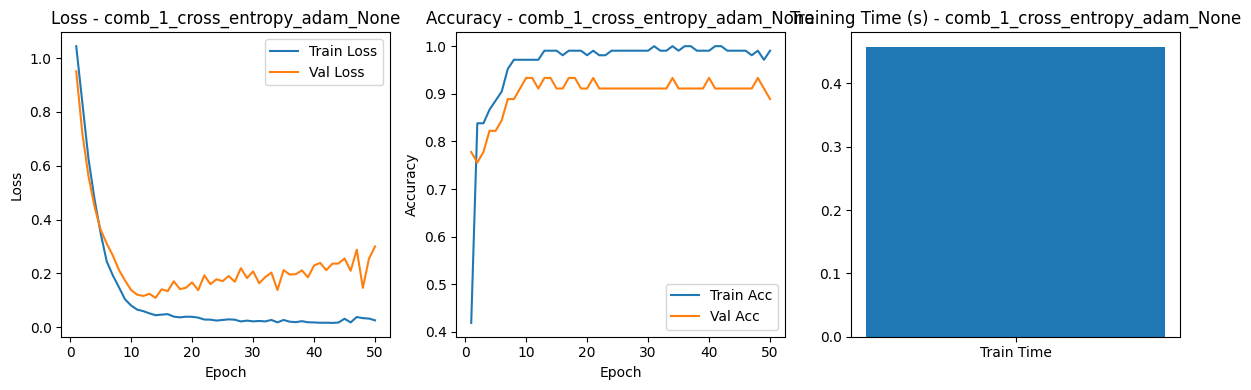

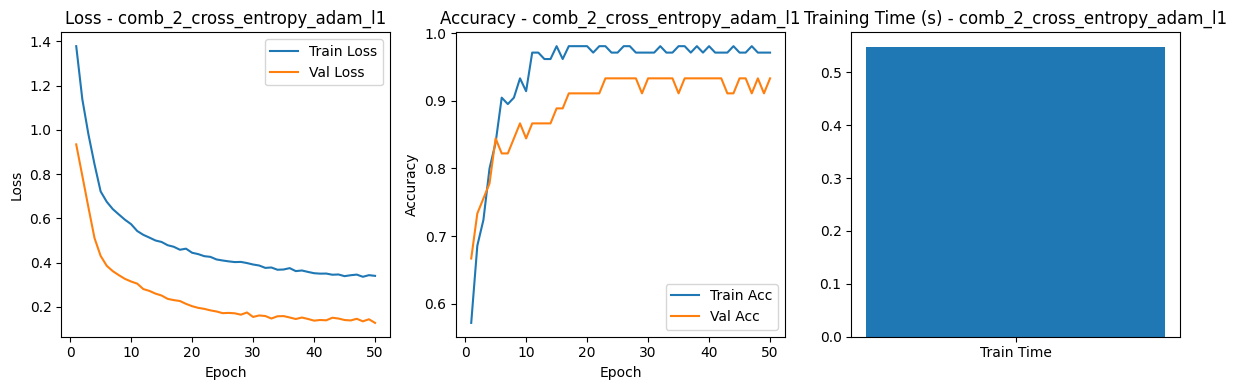

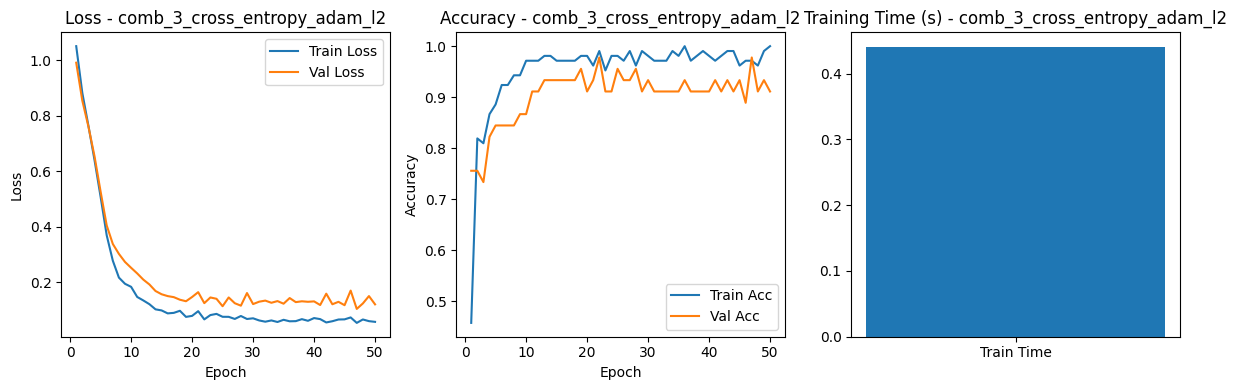

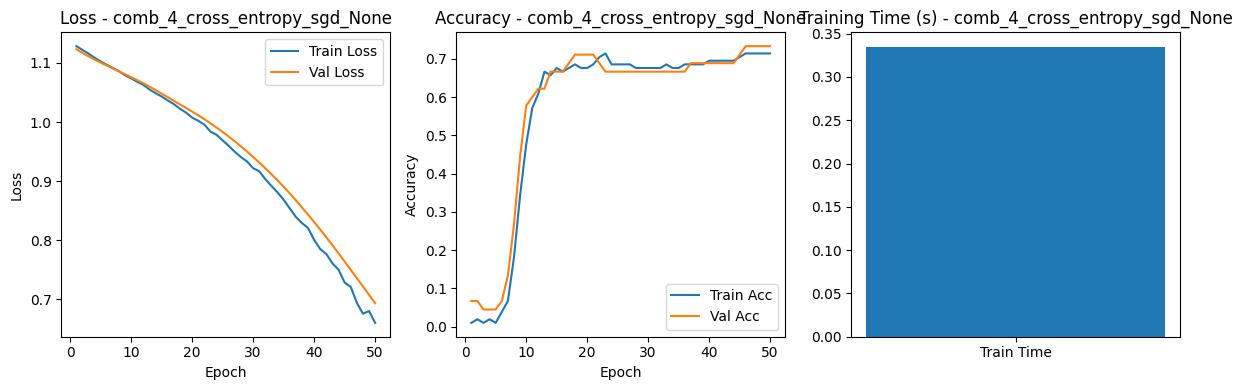

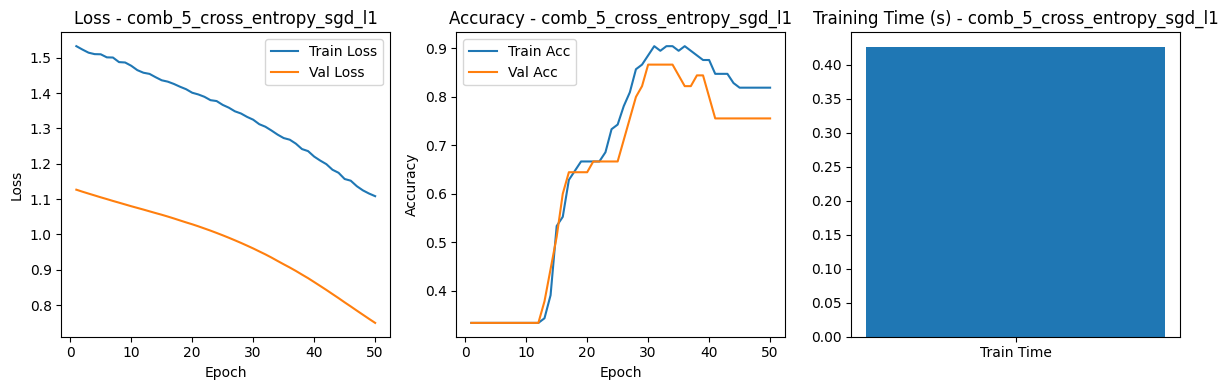

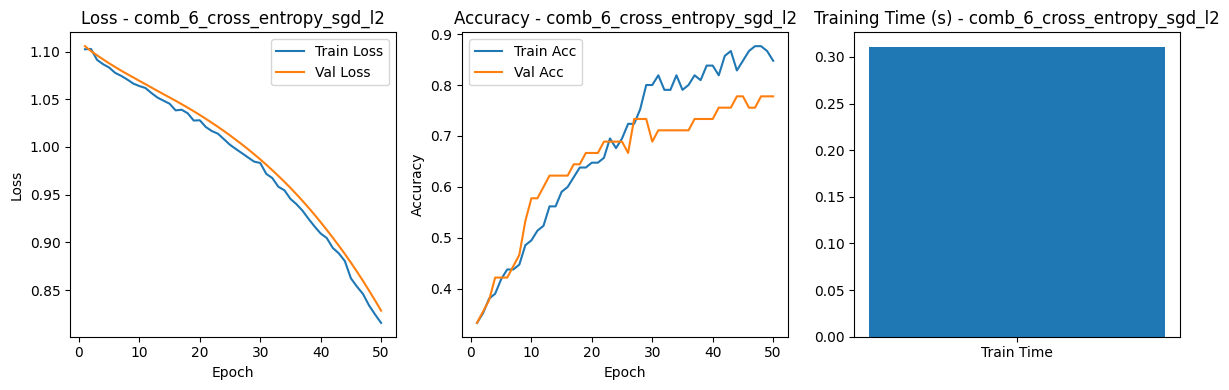

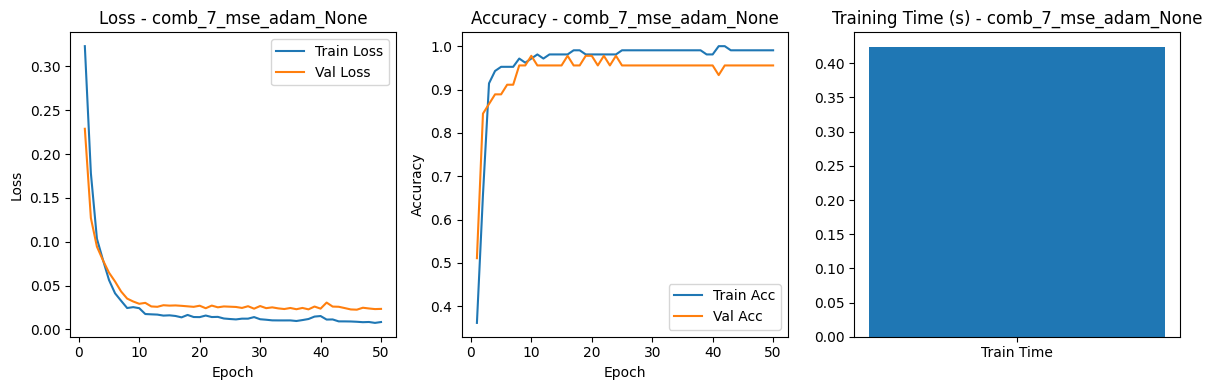

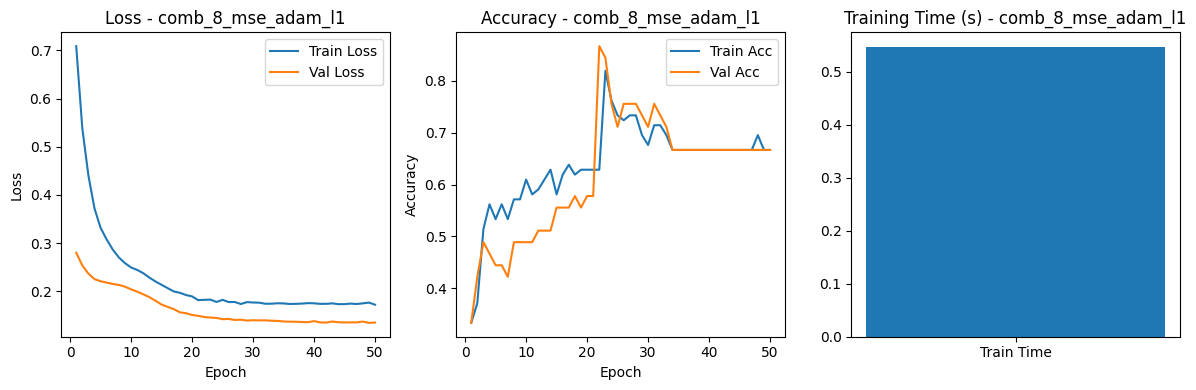

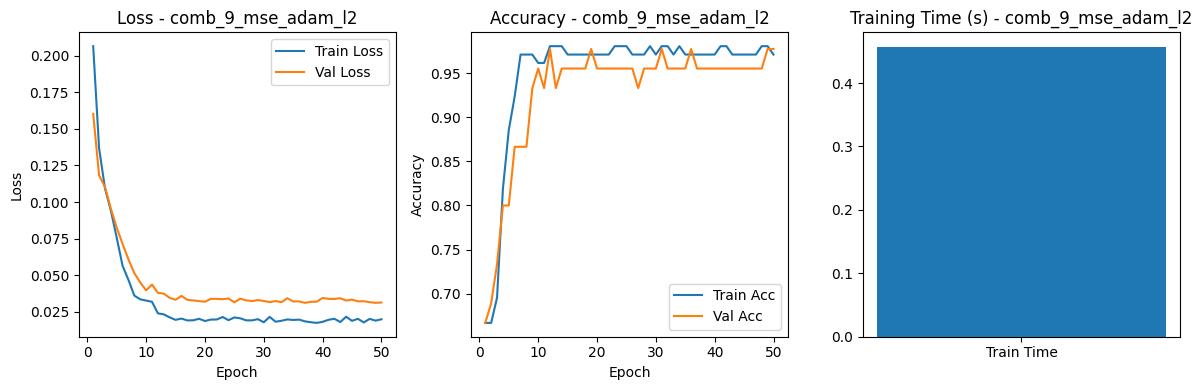

In [28]:
def plot_metrics(results):
    for key, history in results.items():
        epochs = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.plot(epochs, history['train_loss'], label="Train Loss")
        plt.plot(epochs, history['val_loss'], label="Val Loss")
        plt.title(f"Loss - {key}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        
        plt.subplot(1,3,2)
        plt.plot(epochs, history['train_acc'], label="Train Acc")
        plt.plot(epochs, history['val_acc'], label="Val Acc")
        plt.title(f"Accuracy - {key}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.subplot(1,3,3)
        plt.bar(["Train Time"], [history["time"]])
        plt.title(f"Training Time (s) - {key}")
        
        plt.tight_layout()
        plt.show()

plot_metrics(results)
